In [127]:
import pandas as pd

dados = pd.read_csv('reviews.csv')
print(dados.head(10))

                               reviewId app_name  \
0  01e23c15-44bf-46b7-b280-40e880d9d49b   Shopee   
1  df40ba7c-075d-48dc-b798-21466dfb41d6   Shopee   
2  59490b23-b17b-4bba-855b-b5053dadc0db   Shopee   
3  48fd8168-1e42-4475-9a99-935c2fd48769   Shopee   
4  f4e1468b-6d97-4f1a-927d-1afee2bfbe75   Shopee   
5  2ce2db50-eec3-4cf5-afd6-b153ca01cf0f   Shopee   
6  404d8ede-bf3e-4652-a410-ec1ad12e40df   Shopee   
7  0d7c4353-a8f6-467c-abd7-c65b26fd4976   Shopee   
8  5410fc9e-d51f-4f6f-9fdc-01b93eed8750   Shopee   
9  31458c8f-8f11-496f-b72e-dacc9470a52f   Shopee   

                                             content sentiment_polarity  \
0  O app da Shopee é razoável. Apesar de ser fáci...           positive   
1  O app é bem otimizado, fácil de visualizar os ...           positive   
2  O app é muito bom, prático e fácil de entender...           positive   
3  Aplicativo muito bom. Mas algo que me chateou ...           positive   
4  o app é muito bom, porém tenho tido dificuldad...

In [128]:
dados.describe()

,reviewId,app_name,content,sentiment_polarity,sentiment,Unnamed: 5
count,3011,3011,3011,3011,3011,1
unique,3011,10,3011,3,7,1
top,01e23c15-44bf-46b7-b280-40e880d9d49b,Shopee,O app da Shopee é razoável. Apesar de ser fáci...,negative,disgust,X
freq,1,303,1,1742,952,1


In [129]:
#removendo caracteres nao latinos

import regex

dados['content'] = dados['content'].apply(lambda x: regex.sub(r'[^\p{Latin}]', ' ', str(x)))

dados.loc[0, 'content']

'O app da Shopee é razoável  Apesar de ser fácil de utilizar  apresenta alguns bugs  Por exemplo  Sugestão de palavra errada no campo de pesquisa que acarreta na busca errada  Sugestões de produtos que não têm nada a ver com coisas de nosso interesse  Dificuldade de acesso de alguns jogos ou travamento durante alguma jogada  Falhas para carregar certos anexos para avaliação dos produtos  No geral  são problemas que se pode contornar  pois não ocorrem com tanta frequência '

In [130]:
#colocando todo texto para minusculo

dados['content'] = dados['content'].apply(lambda x: str(x).lower())

dados.loc[0, 'content']

'o app da shopee é razoável  apesar de ser fácil de utilizar  apresenta alguns bugs  por exemplo  sugestão de palavra errada no campo de pesquisa que acarreta na busca errada  sugestões de produtos que não têm nada a ver com coisas de nosso interesse  dificuldade de acesso de alguns jogos ou travamento durante alguma jogada  falhas para carregar certos anexos para avaliação dos produtos  no geral  são problemas que se pode contornar  pois não ocorrem com tanta frequência '

In [131]:
import nltk #caso não funcione, adicione a linha nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(texto):
    stops_list = stopwords.words("portuguese")
    word_tokens = word_tokenize(texto)
    texto_sem_stops = [w for w in word_tokens if w not in stops_list]
    return " ".join(texto_sem_stops)
dados['content'] = dados['content'].apply(remove_stopwords)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\biels\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biels\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [132]:
dados.loc[0, 'content']

'app shopee razoável apesar fácil utilizar apresenta alguns bugs exemplo sugestão palavra errada campo pesquisa acarreta busca errada sugestões produtos têm nada ver coisas interesse dificuldade acesso alguns jogos travamento durante alguma jogada falhas carregar certos anexos avaliação produtos geral problemas pode contornar pois ocorrem tanta frequência'

EXTRACAO DAS FEATURES

In [133]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Carregar os dados de reviews

categorias = dados['sentiment']  # Extraindo as categorias de sentimento
categorias_polaridade = dados['sentiment_polarity']  # Extraindo a polaridade do sentimento

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(dados['content'], categorias, test_size=0.2, random_state=42)

# Inicializando o Tokenizer para converter texto em sequências numéricas
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # Treinando o Tokenizer com os dados de treino

# Preparando as sentenças para o modelo Word2Vec
sentences = [sentence.split() for sentence in X_train]
# Treinando o modelo Word2Vec para criar vetores de palavras
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Convertendo as sentenças de treino e teste em sequências numéricas
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Definindo o tamanho do vocabulário e o comprimento máximo das sequências
vocab_size = len(tokenizer.word_index) + 1  # +1 para incluir o índice zero
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))

# Padronizando as sequências para que todas tenham o mesmo comprimento
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Criar a matriz de embeddings usando os vetores de palavras treinados pelo Word2Vec
embedding_matrix = np.zeros((vocab_size, 100))  # Inicializa uma matriz de zeros
for word, i in tokenizer.word_index.items():  # Para cada palavra no vocabulário
    if word in w2v_model.wv:  # Verifica se a palavra tem um vetor correspondente no modelo Word2Vec
        embedding_matrix[i] = w2v_model.wv[word]  # Associa o vetor da palavra à matriz de embeddings

# Codificando as categorias de rótulos em números inteiros
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convertendo os rótulos para codificação one-hot
num_classes = len(label_encoder.classes_)
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

# Criando a arquitetura do modelo de rede neural
model = Sequential()
# Adicionando a camada de embedding que usa a matriz de embeddings criada
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))

# Adicionando a primeira camada convolucional e uma camada de pooling
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))  # pool_size reduzido para 1 para evitar problemas de dimensão

# Adicionando a segunda camada convolucional e uma camada de pooling
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))  # pool_size reduzido para 1 para evitar problemas de dimensão

# Adicionando uma camada de flattening para converter a saída em uma única dimensão
model.add(Flatten())
# Adicionando uma camada totalmente conectada com 128 unidades e função de ativação ReLU
model.add(Dense(128, activation='relu'))
# Adicionando a camada de saída com softmax para classificação multi-classe
model.add(Dense(num_classes, activation='softmax'))

# Compilando o modelo com otimizador Adam e função de perda categórica
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinando o modelo com os dados de treino
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))







Epoch 1/10


C:\Users\biels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3210 - loss: 1.5601 - val_accuracy: 0.3184 - val_loss: 1.4817
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3708 - loss: 1.4417 - val_accuracy: 0.3333 - val_loss: 1.5016
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4185 - loss: 1.3713 - val_accuracy: 0.3350 - val_loss: 1.4614
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4212 - loss: 1.3345 - val_accuracy: 0.3151 - val_loss: 1.5050
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4371 - loss: 1.2578 - val_accuracy: 0.3599 - val_loss: 1.5074
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5000 - loss: 1.1909 - val_accuracy: 0.3367 - val_loss: 1.5329
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5534 - loss: 1.0618 - val_accuracy: 0.3035 - val_loss: 1.6108
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6287 - loss: 0.9581 - val_accuracy: 0.3300 - val_loss: 1.

In [134]:
predicoes = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [135]:
print(classification_report(y_test_labels, predicoes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       anger       0.28      0.37      0.32       153
     disgust       0.35      0.39      0.37       188
        fear       0.00      0.00      0.00         5
   happiness       0.09      0.06      0.07        64
     neutral       0.00      0.00      0.00        19
     sadness       0.36      0.27      0.31       172
    surprise       0.00      0.00      0.00         2

    accuracy                           0.30       603
   macro avg       0.15      0.15      0.15       603
weighted avg       0.29      0.30      0.29       603



C:\Users\biels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\biels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\biels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

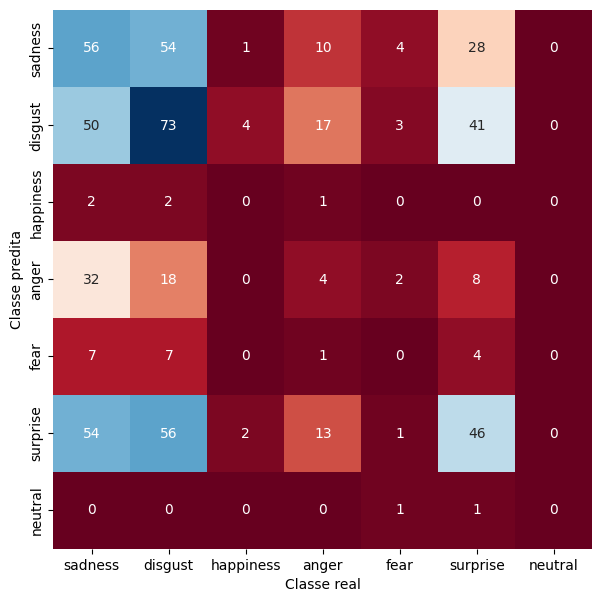

In [136]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_labels = dados['sentiment'].unique()

# Geração da matriz de confusão
cm = confusion_matrix(y_test_labels, predicoes)
plt.figure(figsize=(10, 7))  # Ajuste o tamanho do gráfico conforme necessário
sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False,
            xticklabels=categorias.unique(), yticklabels=categorias.unique())


plt.xlabel('Classe real')
plt.ylabel('Classe predita')
plt.show()

POLARIDADE SENTIMENTOS


In [137]:
X_train, X_test, y_train, y_test = train_test_split(dados['content'], categorias_polaridade, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Criar a matriz de embeddings
embedding_matrix = np.zeros((vocab_size, 100)) 
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))

# Modificação: Alterando o pool_size para evitar dimensão negativa
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))  # pool_size reduzido para 1

model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))  # pool_size reduzido para 1

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


C:\Users\biels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5228 - loss: 0.8301 - val_accuracy: 0.5738 - val_loss: 0.7834
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5872 - loss: 0.7631 - val_accuracy: 0.5854 - val_loss: 0.7726
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6117 - loss: 0.7359 - val_accuracy: 0.5837 - val_loss: 0.7829
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6161 - loss: 0.7057 - val_accuracy: 0.5871 - val_loss: 0.7881
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6463 - loss: 0.6813 - val_accuracy: 0.5837 - val_loss: 0.8773
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6759 - loss: 0.6355 - val_accuracy: 0.5854 - val_loss: 0.8086
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7036 - loss: 0.5893 - val_accuracy: 0.5837 - val_loss: 0.8320
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7639 - loss: 0.5127 - val_accuracy: 0.5904 - val_loss: 0.

In [138]:
predicoespolarity = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [139]:
print(classification_report(y_test_labels, predicoespolarity, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.62      0.81      0.70       346
     neutral       0.00      0.00      0.00        19
    positive       0.54      0.34      0.41       238

    accuracy                           0.60       603
   macro avg       0.39      0.38      0.37       603
weighted avg       0.57      0.60      0.57       603



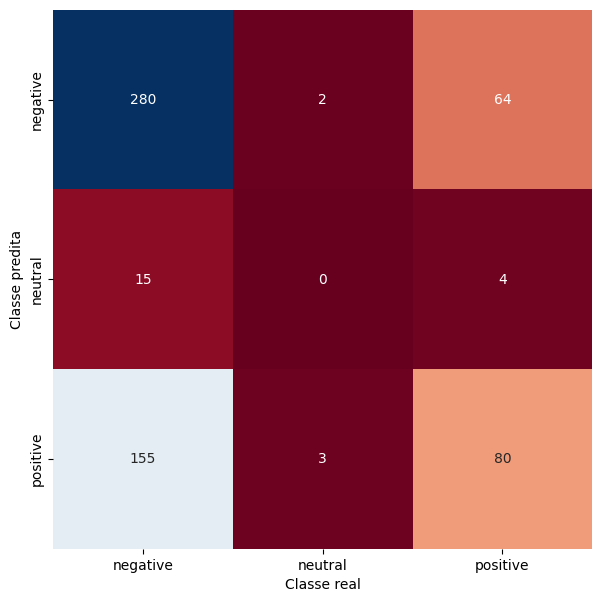

In [140]:
cm = confusion_matrix(y_test_labels, predicoespolarity)
plt.figure(figsize=(10, 7))  # Ajuste o tamanho do gráfico conforme necessário
sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False,
                        xticklabels=label_encoder.classes_,
                        yticklabels=label_encoder.classes_)



plt.xlabel('Classe real')
plt.ylabel('Classe predita')
plt.show()